# Testing K-means Clustering
### Use techniques we've already learned in class to try and make progress on identifying roads

Imports

In [122]:
import skimage.io as skio
import skimage.util as sku
import skimage.color as skol
from skimage import filters, feature, transform
import skimage.morphology as skimor
import skimage.draw as draw
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from scipy.ndimage import gaussian_filter, gaussian_laplace
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import datasets
import tensorflow.keras.backend as K

### Read data file and show images

In [123]:
image_filepath = "../../data/massRoads/tiff"
# /train/... for images and /train_labels/... for labels

In [124]:
image = skio.imread(image_filepath + "/train/10528735_15.tiff")
image_label = skio.imread(image_filepath + "/train_labels/10528735_15.tif")

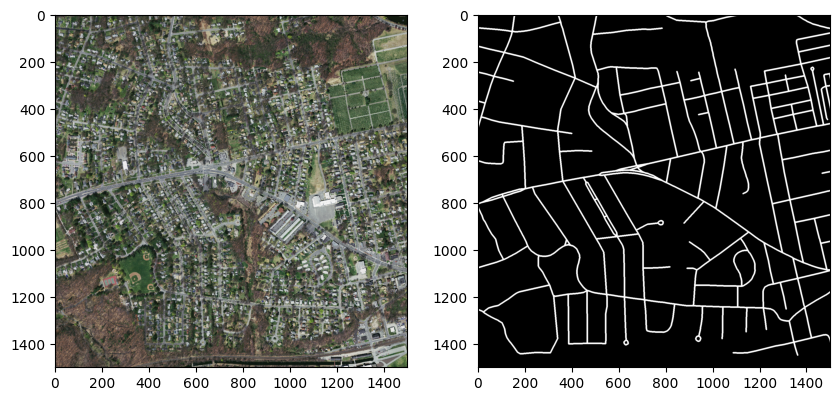

In [125]:
fig, axes = plt.subplots(1,2, figsize = (10,15))

axes[0].imshow(image)
axes[1].imshow(image_label, cmap='gray')

plt.show()

Cropping Image for testing

In [126]:
x1, x2 = 450, 550
y1, y2 = 675, 750
image = image[y1:y2, x1:x2, :]
image_label = image_label[y1:y2, x1:x2]

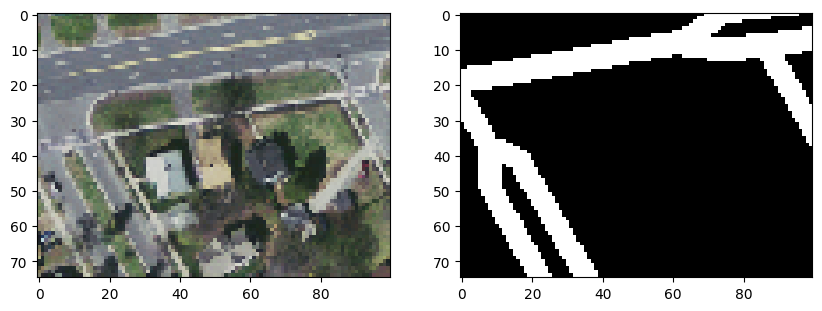

In [127]:
fig, axes = plt.subplots(1,2, figsize = (10,15))

axes[0].imshow(image)
axes[1].imshow(image_label, cmap='gray')

plt.show()

### Function for calculating label accuracy

In [128]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

In [129]:
# Function to print several accuracy metrics
def accuracy_metrics(y_true, y_pred):
    # Create confusion matrix
    C = confusion_matrix(y_true, y_pred, labels=(True, False))

    # Overall accuracy rate
    acc = (C[0,0] + C[1,1])/C.sum()

    # Recall
    recall = (C[0,0])/(C[0,0] + C[1,0])
    
    # Precision
    prec = (C[0,0])/(C[0,0] + C[0,1])

    dice = dice_coef(y_true=y_true, y_pred=y_pred)

    # Print results
    print("Confusion matrix:\n", C)
    print("Overall accuracy:", np.round(acc, 3), "\nPrecision:", np.round(recall, 3), "\nRecall", np.round(prec, 3), "\nDice Coefficient", np.round(dice, 3)) 

In [130]:
#what values are used in label image
np.unique(image_label)

array([  0, 255], dtype=uint8)

### Reshape image

In [131]:
pixel_vals = image.reshape((-1,3))
pixel_vals = np.float32(pixel_vals)

### K means from sklearn with just RGB

In [132]:
sk_kmeans = KMeans(n_clusters=3, verbose=1).fit(pixel_vals)

Initialization complete
Iteration 0, inertia 9151501.0.
Iteration 1, inertia 6988855.0.
Iteration 2, inertia 6884783.0.
Iteration 3, inertia 6869388.5.
Iteration 4, inertia 6865800.5.
Iteration 5, inertia 6864909.0.
Converged at iteration 5: center shift 0.06919966638088226 within tolerance 0.18099222412109375.


In [133]:
sk_segmented_image_pca = sk_kmeans.labels_.reshape((image.shape[0], image.shape[1]))

/Users/aidenpape/miniconda3/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


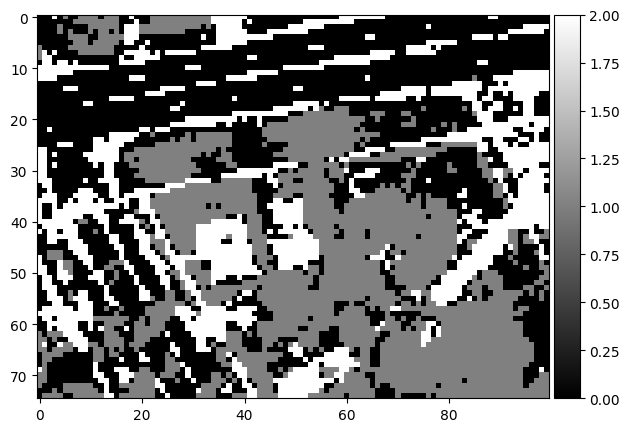

In [134]:
skio.imshow(sk_segmented_image_pca, cmap='gray')

### Let's try to input a few more things into the model

Let's try to put a horizontal and vertically run edge detection using Sobel kernels

In [135]:
image_gray = skol.rgb2gray(image)

# Define Sobel kernels
sobel_horizontal = np.array([[-1, -2, -1],
                             [ 0,  0,  0],
                             [ 1,  2,  1]])

sobel_vertical = np.array([[-1, 0, 1],
                           [-2, 0, 2],
                           [-1, 0, 1]])

# Perform convolutions
edges_horizontal = convolve2d(image_gray, sobel_horizontal, mode='same', boundary='symm')
edges_vertical = convolve2d(image_gray, sobel_vertical, mode='same', boundary='symm')

# Calculate the magnitude of the gradient
edges = np.sqrt(np.square(edges_horizontal) + np.square(edges_vertical))

/Users/aidenpape/miniconda3/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


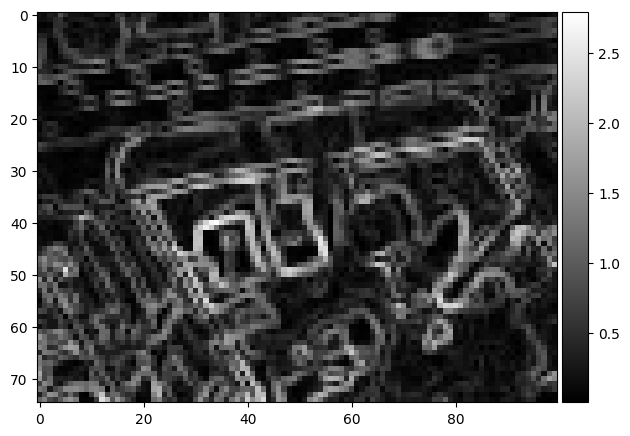

In [136]:
skio.imshow(edges, cmap='gray')

## Let's use canny edge detection instead

In [137]:
# Calculation Canny gradient
canny_edges = feature.canny(image_gray, sigma=3)

### Dilation to create crisper edges

In [138]:
# Create disk
disk = skimor.disk(1)

# Area closing
closed_edges = skimor.dilation(canny_edges, footprint = disk)
closed_edges = closed_edges * 255

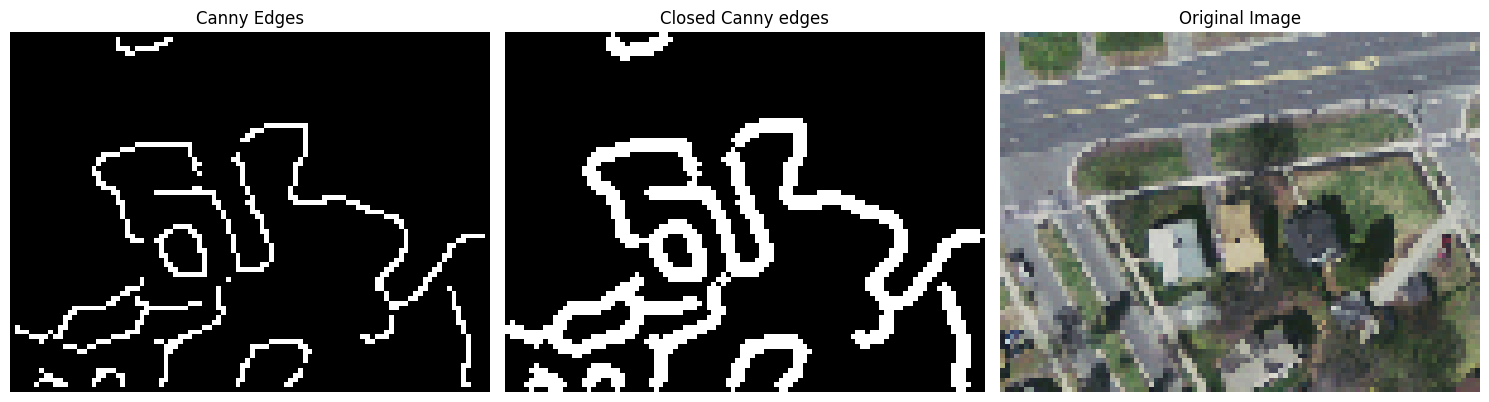

In [139]:
# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(canny_edges, cmap='gray')
ax[0].set_title('Canny Edges')

ax[1].imshow(closed_edges, cmap='gray')
ax[1].set_title('Closed Canny edges')

ax[2].imshow(image)
ax[2].set_title('Original Image')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

Now lets add this new channel to the image and see what happens

In [140]:
image_with_canny = np.dstack((image, closed_edges.astype(np.uint8) * 255))

In [141]:
feature_vals = image_with_canny.reshape((-1,4))
feature_vals = np.float32(feature_vals)

In [142]:
sk_kmeans = KMeans(n_clusters=3, verbose=1).fit(feature_vals)

Initialization complete
Iteration 0, inertia 7957098.0.
Iteration 1, inertia 6929594.5.
Iteration 2, inertia 6871233.0.
Iteration 3, inertia 6866522.5.
Iteration 4, inertia 6865844.0.
Converged at iteration 4: center shift 0.07451267540454865 within tolerance 0.13574781494140625.


In [143]:
sk_segmented_image_pca = sk_kmeans.labels_.reshape((image.shape[0], image.shape[1]))

/Users/aidenpape/miniconda3/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


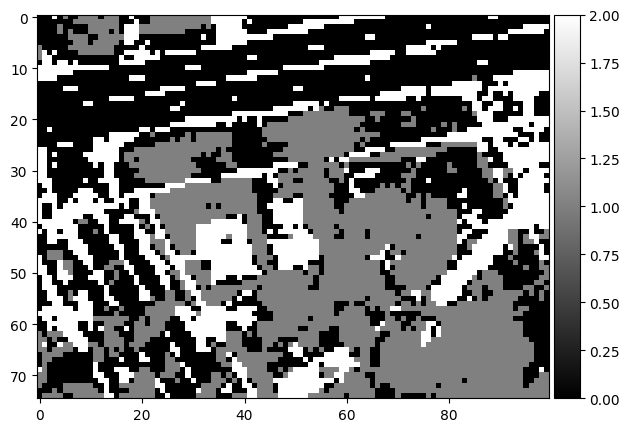

In [144]:
skio.imshow(sk_segmented_image_pca, cmap='gray')

In [145]:
np.unique(sk_segmented_image_pca)

array([0, 1, 2], dtype=int32)

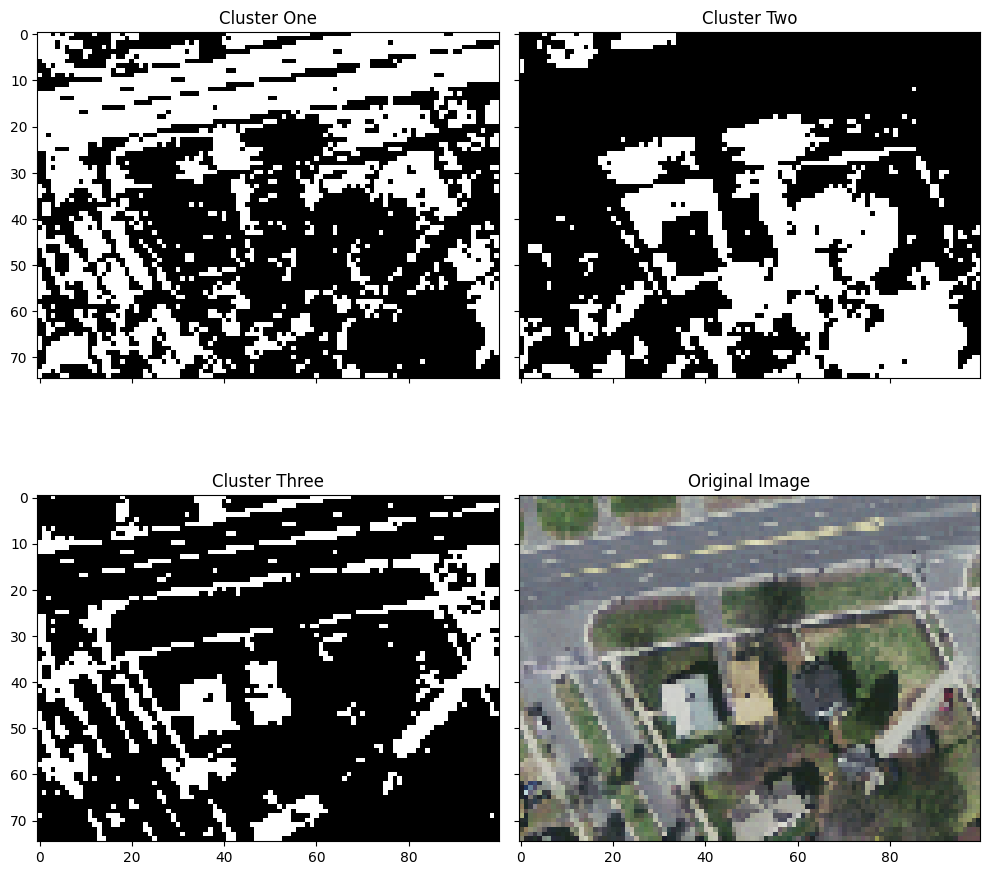

In [146]:
# Generating figure 2
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

cluster_one = (sk_segmented_image_pca==0)
axes[0][0].imshow(cluster_one, cmap='gray')
axes[0][0].set_title('Cluster One')

cluster_two = (sk_segmented_image_pca==1)
axes[0][1].imshow(cluster_two, cmap='gray')
axes[0][1].set_title('Cluster Two')

cluster_three = (sk_segmented_image_pca==2)
axes[1][0].imshow(cluster_three, cmap='gray')
axes[1][0].set_title('Cluster Three')

axes[1][1].imshow(image)
axes[1][1].set_title('Original Image')


plt.tight_layout()
plt.show()

### Hough Transform for detecting straight edges

In [147]:
lines = transform.probabilistic_hough_line(closed_edges, threshold=5, line_length=25, line_gap=3)

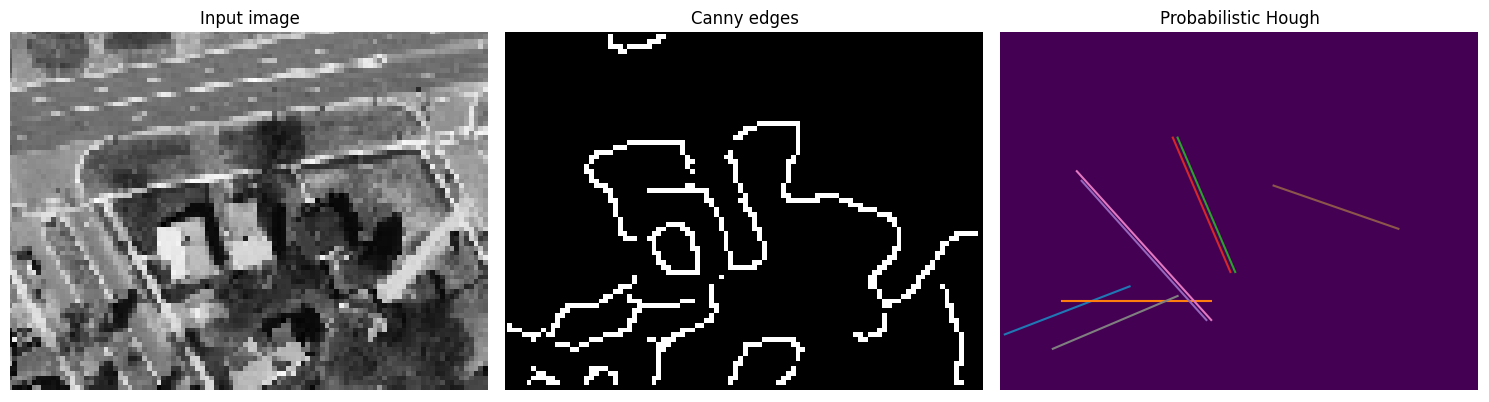

In [148]:
# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image_gray, cmap='gray')
ax[0].set_title('Input image')

ax[1].imshow(canny_edges, cmap='gray')
ax[1].set_title('Canny edges')

ax[2].imshow(canny_edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image_gray.shape[1]))
ax[2].set_ylim((image_gray.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

In [149]:
# Create a blank canvas to draw lines on
hough_lines = np.zeros(image_gray.shape, dtype=np.uint8)

# Draw the detected lines on the canvas
for line in lines:
    p0, p1 = line
    # Draw line segment
    rr, cc = draw.line(p0[1], p0[0], p1[1], p1[0])
    hough_lines[rr, cc] = 255  # Set the pixel values to white (255) along the line

# # Display the canvas with the detected lines
# plt.imshow(hough_lines, cmap='gray')
# plt.title('Image with Detected Lines')
# plt.axis('off')
# plt.show()

## Let's try to classify gray pixels, these may help identify the roads

In [150]:
def classify_gray(image):

    # Convert the image to Lab color space

    # Compute the standard deviation of the r, g, and b channels
    # std_dev = np.std(image[:,:,0], image[:,:,1], image[:,:,2])
    std_dev = np.std(image, axis = 2)

    # Define a threshold for classifying gray pixels
    diff_threshold = 6 # Adjust as needed

    # Classify pixels as gray or not gray based on the standard deviation
    gray_mask = std_dev < diff_threshold
        
    return gray_mask

In [151]:
gray_mask = classify_gray(image)
gray_mask = gray_mask.reshape((image.shape[0], image.shape[1]))

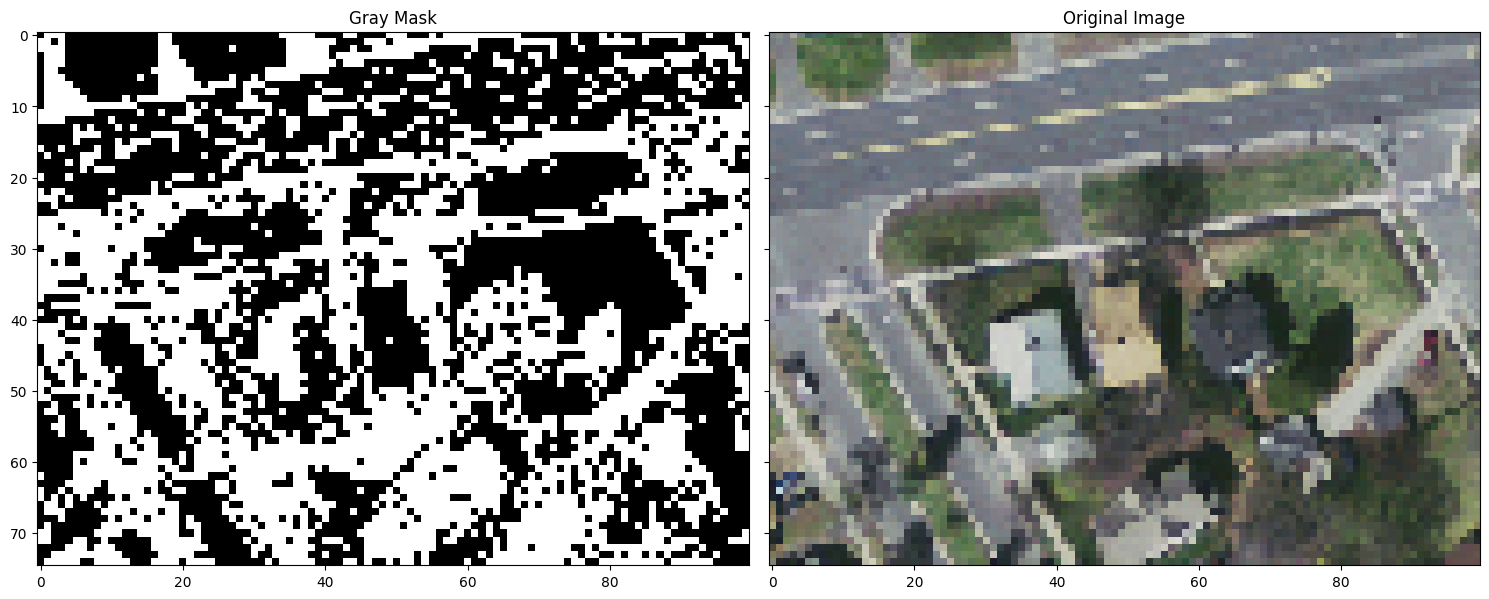

In [152]:
# Generating figure 2
fig, axes = plt.subplots(1, 2, figsize=(15, 10), sharex=True, sharey=True)

axes[0].imshow(gray_mask, cmap='gray')
axes[0].set_title('Gray Mask')

axes[1].imshow(image)
axes[1].set_title('Original Image')

plt.tight_layout()
plt.show()

### More features

In [153]:
# Create additional features

# Range of values (gray pixels will have low range)
r = image.max(axis = 2) - image.min(axis = 2)

# Canny edge detection
canny_edges_r = feature.canny(image[:,:,0], sigma=4);
canny_edges_g = feature.canny(image[:,:,1], sigma=4);
canny_edges_b = feature.canny(image[:,:,2], sigma=4);

# Gaussian blur sigma = 1
gaus_r_1 = gaussian_filter(image[:,:,0], sigma = 1)
gaus_g_1 = gaussian_filter(image[:,:,1], sigma = 1)
gaus_b_1 = gaussian_filter(image[:,:,2], sigma = 1)

# Gaussian blur sigma = 3
gaus_r_3 = gaussian_filter(image[:,:,0], sigma = 3)
gaus_g_3 = gaussian_filter(image[:,:,1], sigma = 3)
gaus_b_3 = gaussian_filter(image[:,:,2], sigma = 3)

# Gaussian blur sigma = 5
gaus_r_5 = gaussian_filter(image[:,:,0], sigma = 5)
gaus_g_5 = gaussian_filter(image[:,:,1], sigma = 5)
gaus_b_5 = gaussian_filter(image[:,:,2], sigma = 5)

# LoG blur sigma = .5
log_r_5 = gaussian_laplace(image[:,:,0], sigma = .5)
log_g_5 = gaussian_laplace(image[:,:,1], sigma = .5)
log_b_5 = gaussian_laplace(image[:,:,2], sigma = .5)

# LoG blur sigma = .6
log_r_6 = gaussian_laplace(image[:,:,0], sigma = .6)
log_g_6 = gaussian_laplace(image[:,:,1], sigma = .6)
log_b_6 = gaussian_laplace(image[:,:,2], sigma = .6)

# LoG blur sigma = .8
log_r_8 = gaussian_laplace(image[:,:,0], sigma = .8)
log_g_8 = gaussian_laplace(image[:,:,1], sigma = .8)
log_b_8 = gaussian_laplace(image[:,:,2], sigma = .8)

# Add layers to model
image_layers = np.dstack([image, r, canny_edges_r, canny_edges_g, canny_edges_b,
                             gaus_r_1, gaus_g_1, gaus_b_1, gaus_r_3, gaus_g_3, gaus_b_3,
                             gaus_r_5, gaus_g_5, gaus_b_5, log_r_5, log_g_5, log_b_5,
                             log_r_6, log_g_6, log_b_6, log_r_8, log_g_8, log_b_8, hough_lines, gray_mask])

## PCA to select important features

In [154]:
image_layers.shape

(75, 100, 27)

In [155]:
image_layers = image_layers.reshape(image_layers.shape[0] * image_layers.shape[1], image_layers.shape[2])
image_layers.shape

(7500, 27)

In [156]:
# Standardize the features
scaler = StandardScaler()
image_layers_scaled = scaler.fit_transform(image_layers)

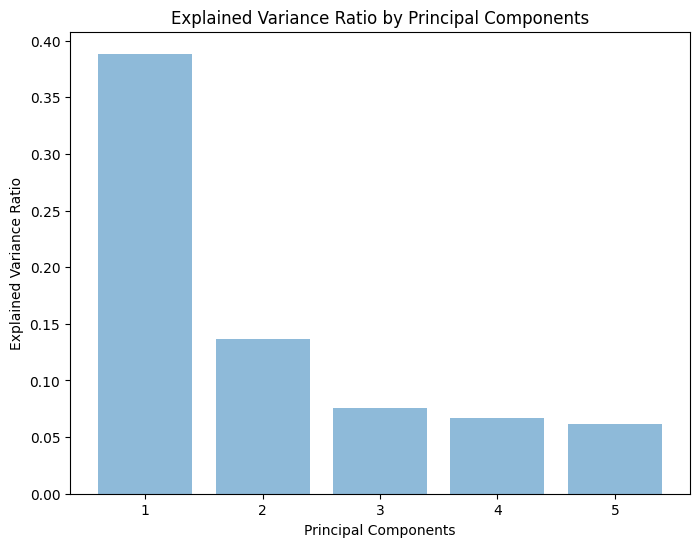

In [157]:
# Initialize PCA and fit the scaled data
pca = PCA(n_components=5)
layers_pca = pca.fit_transform(image_layers_scaled)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plotting the explained variance ratio
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.title('Explained Variance Ratio by Principal Components')
plt.show()

In [158]:
layers_pca.shape

(7500, 5)

Transform to create new features in less dimensions

In [159]:
new_features = pca.transform(image_layers_scaled)

In [160]:
new_features.shape

(7500, 5)

### Run k_means clustering with 3 top components from PCA

In [161]:
sk_kmeans_pca = KMeans(n_clusters=3, verbose=1).fit(new_features)

Initialization complete
Iteration 0, inertia 123716.19268453149.
Iteration 1, inertia 81206.56131639544.
Iteration 2, inertia 80379.63761496074.
Iteration 3, inertia 80248.56084677183.
Iteration 4, inertia 80221.05356165496.
Iteration 5, inertia 80216.4490686662.
Converged at iteration 5: center shift 0.00034726557264135494 within tolerance 0.00039411965957254487.


In [162]:
sk_segmented_image_pca = sk_kmeans.labels_.reshape((image.shape[0], image.shape[1]))

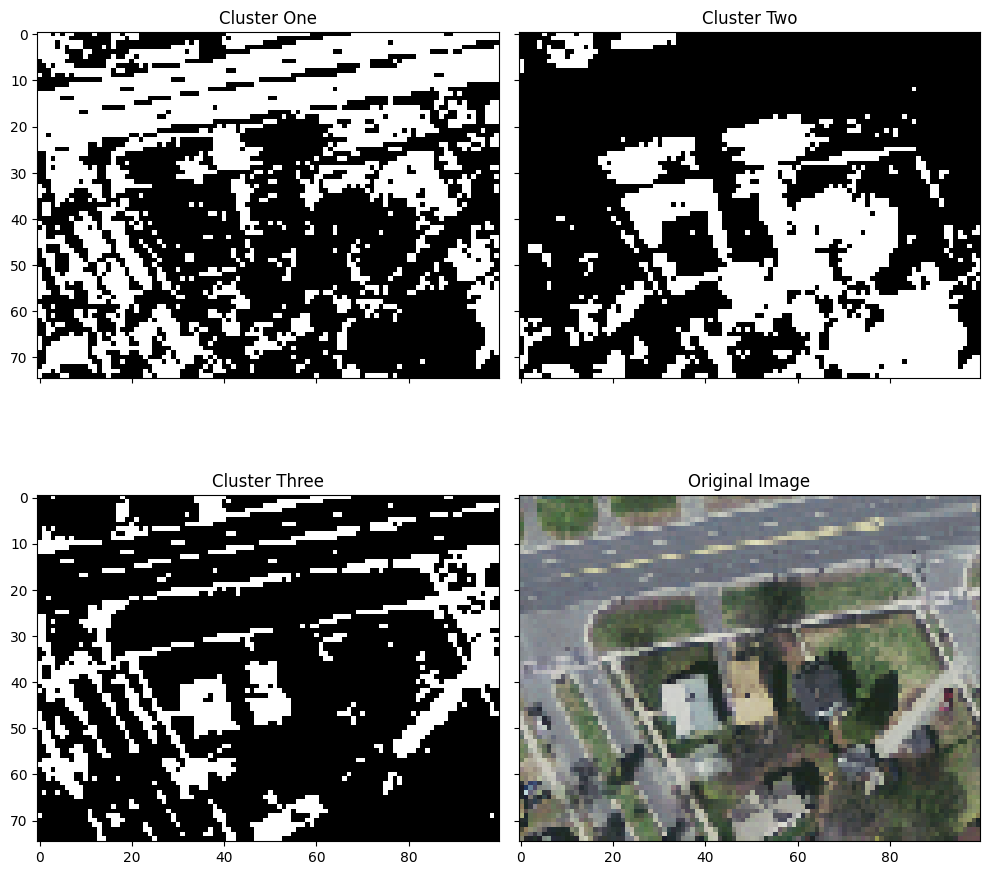

In [163]:
# Generating figure 2
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

cluster_one = (sk_segmented_image_pca==0)
axes[0][0].imshow(cluster_one, cmap='gray')
axes[0][0].set_title('Cluster One')

cluster_two = (sk_segmented_image_pca==1)
axes[0][1].imshow(cluster_two, cmap='gray')
axes[0][1].set_title('Cluster Two')

cluster_three = (sk_segmented_image_pca==2)
axes[1][0].imshow(cluster_three, cmap='gray')
axes[1][0].set_title('Cluster Three')

axes[1][1].imshow(image)
axes[1][1].set_title('Original Image')


plt.tight_layout()
plt.show()

Which cluster best captures the roads? Let's find out with the results

In [164]:
image_label_bool = (image_label==255)

In [165]:
cluster_one.dtype

dtype('bool')

In [166]:
accuracy_metrics(image_label_bool.ravel(), cluster_one.ravel())

Confusion matrix:
 [[1078  499]
 [2255 3668]]
Overall accuracy: 0.633 
Precision: 0.323 
Recall 0.684 
Dice Coefficient 0.439


In [167]:
accuracy_metrics(image_label_bool.ravel(), cluster_two.ravel())

Confusion matrix:
 [[ 109 1468]
 [2356 3567]]
Overall accuracy: 0.49 
Precision: 0.044 
Recall 0.069 
Dice Coefficient 0.054


In [168]:
accuracy_metrics(image_label_bool.ravel(), cluster_three.ravel())

Confusion matrix:
 [[ 390 1187]
 [1312 4611]]
Overall accuracy: 0.667 
Precision: 0.229 
Recall 0.247 
Dice Coefficient 0.238


In [169]:
def identify_road_cluster(clustered_image, image_label):

    cluster_labels = np.unique(clustered_image)

    best_precision = 0
    best_cluster = -1

    for i in cluster_labels:
        cluster = (sk_segmented_image_pca==i)
        C = confusion_matrix(image_label.ravel(), cluster.ravel(), labels=(True, False))

        # # Overall accuracy rate
        # acc = (C[0,0] + C[1,1])/C.sum()
        # # Recall
        # recall = (C[0,0])/(C[0,0] + C[1,0])
        # Precision
        prec = (C[0,0])/(C[0,0] + C[0,1])

        if prec > best_precision:
            best_precision = prec
            best_cluster = i

    return best_cluster

In [170]:
cluster = identify_road_cluster(sk_segmented_image_pca, image_label_bool)

In [171]:
image_label

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

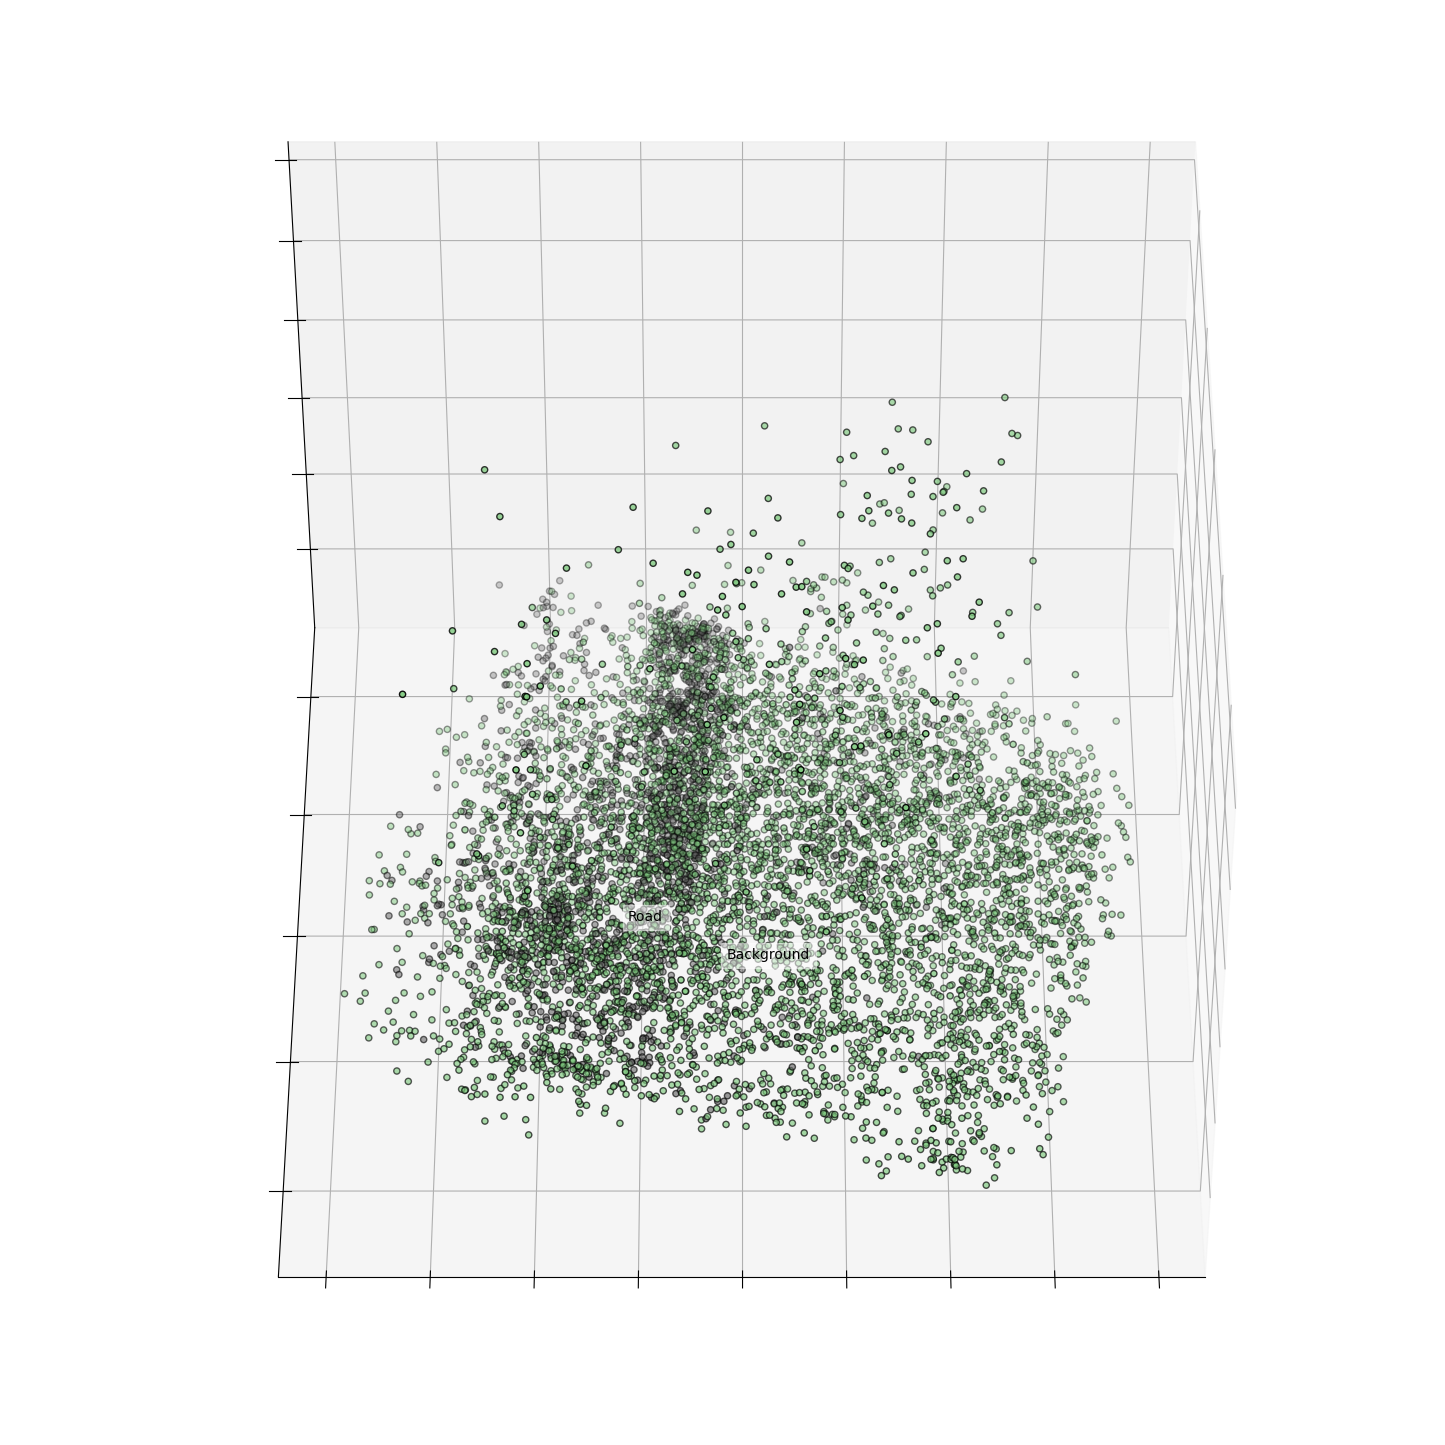

In [180]:
fig = plt.figure(1, figsize=(15, 15))
plt.clf()

ax = fig.add_subplot(111, projection="3d", elev=45, azim=90)
ax.set_position([0, 0, 0.95, 1])

X = new_features
y = image_label.ravel()

for name, label in [("Background", 0), ("Road", 255)]:
    ax.text3D(
        X[y == label, 0].mean(),
        X[y == label, 1].mean() + 1.5,
        X[y == label, 2].mean(),
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.5, edgecolor="w", facecolor="w"),
    )
# Reorder the labels to have colors matching the cluster results
# y = np.choose(y, [0, 255]).astype(float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='Accent', edgecolor="k")

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

plt.show()

In [173]:
def create_features(image):

    # Calculation Canny gradient
    image_gray = skol.rgb2gray(image)
    canny_edges = feature.canny(image_gray, sigma=3)

    # Create disk
    disk = skimor.disk(1)

    # Area closing for hough lines
    closed_edges = skimor.dilation(canny_edges, footprint = disk)
    closed_edges = closed_edges * 255

    lines = transform.probabilistic_hough_line(closed_edges, threshold=5, line_length=25, line_gap=3)
    hough_lines = np.zeros(image_gray.shape, dtype=np.uint8)

    # Draw the detected lines on the canvas
    for line in lines:
        p0, p1 = line
        # Draw line segment
        rr, cc = draw.line(p0[1], p0[0], p1[1], p1[0])
        hough_lines[rr, cc] = 255  # Set the pixel values to white (255) along the line

    #create gray mask
    gray_mask = classify_gray(image)
    gray_mask = gray_mask.reshape((image.shape[0], image.shape[1]))

    # Create additional features

    # Range of values (gray pixels will have low range)
    r = image.max(axis = 2) - image.min(axis = 2)

    # Canny edge detection
    canny_edges_r = feature.canny(image[:,:,0], sigma=4);
    canny_edges_g = feature.canny(image[:,:,1], sigma=4);
    canny_edges_b = feature.canny(image[:,:,2], sigma=4);

    # Gaussian blur sigma = 1
    gaus_r_1 = gaussian_filter(image[:,:,0], sigma = 1)
    gaus_g_1 = gaussian_filter(image[:,:,1], sigma = 1)
    gaus_b_1 = gaussian_filter(image[:,:,2], sigma = 1)

    # Gaussian blur sigma = 3
    gaus_r_3 = gaussian_filter(image[:,:,0], sigma = 3)
    gaus_g_3 = gaussian_filter(image[:,:,1], sigma = 3)
    gaus_b_3 = gaussian_filter(image[:,:,2], sigma = 3)

    # Gaussian blur sigma = 5
    gaus_r_5 = gaussian_filter(image[:,:,0], sigma = 5)
    gaus_g_5 = gaussian_filter(image[:,:,1], sigma = 5)
    gaus_b_5 = gaussian_filter(image[:,:,2], sigma = 5)

    # LoG blur sigma = .5
    log_r_5 = gaussian_laplace(image[:,:,0], sigma = .5)
    log_g_5 = gaussian_laplace(image[:,:,1], sigma = .5)
    log_b_5 = gaussian_laplace(image[:,:,2], sigma = .5)

    # LoG blur sigma = .6
    log_r_6 = gaussian_laplace(image[:,:,0], sigma = .6)
    log_g_6 = gaussian_laplace(image[:,:,1], sigma = .6)
    log_b_6 = gaussian_laplace(image[:,:,2], sigma = .6)

    # LoG blur sigma = .8
    log_r_8 = gaussian_laplace(image[:,:,0], sigma = .8)
    log_g_8 = gaussian_laplace(image[:,:,1], sigma = .8)
    log_b_8 = gaussian_laplace(image[:,:,2], sigma = .8)

    # Add layers to model
    image_layers = np.dstack([image, r, canny_edges_r, canny_edges_g, canny_edges_b,
                                gaus_r_1, gaus_g_1, gaus_b_1, gaus_r_3, gaus_g_3, gaus_b_3,
                                gaus_r_5, gaus_g_5, gaus_b_5, log_r_5, log_g_5, log_b_5,
                                log_r_6, log_g_6, log_b_6, log_r_8, log_g_8, log_b_8, hough_lines, gray_mask])
    
    image_layers = image_layers.reshape(image_layers.shape[0] * image_layers.shape[1], image_layers.shape[2])
    
    scaler = StandardScaler()
    image_layers_scaled = scaler.fit_transform(image_layers)

    print(image_layers.shape)
    
    return image_layers

In [174]:
def get_pca(image_layers, n_components):

    # Initialize PCA and fit the scaled data
    pca = PCA(n_components=n_components)
    layers_pca = pca.fit_transform(image_layers)

    # Explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_

    new_features = pca.transform(image_layers)

    return new_features


In [175]:
def run_k_means(image_layers, n_clusters):

    sk_kmeans = KMeans(n_clusters=n_clusters, verbose=1).fit(image_layers)

    sk_segmented_image_pca = sk_kmeans.labels_.reshape((image.shape[0], image.shape[1]))

    best_cluster = identify_road_cluster(sk_segmented_image_pca, image_label)

    segmented_roads = (sk_segmented_image_pca==best_cluster)

    return segmented_roads

In [176]:
def full_pipeline(image, image_label, n_clusters=3, with_pca=False, pca_n_components=5):
    
    print("Creating features...")
    image_layers = create_features(image)
    if(with_pca):
        print("Reducing dimensions...")
        image_layers = get_pca(image_layers=image_layers, n_components=pca_n_components)
    
    print("Segmenting Roads...")
    segmented_roads = run_k_means(image_layers=image_layers, n_clusters=n_clusters)
    print("Segmentation Complete")
    
    plt.imshow(segmented_roads, cmap='gray')
    plt.show()

    print("Analyzing metrics...")
    accuracy_metrics(segmented_roads, image_label)

In [177]:
image.shape

(75, 100, 3)

In [181]:
# full_pipeline(image, image_label_bool)